This notebook shows how to solve a simple Aiygari-model using the `GEModelTools` package. *We solve for the transition path to a MIT-shock.*

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import AiyagariModel
from AiyagariModel import AiygariModelClass

# Setup

In [2]:
model = AiygariModelClass(name='baseline') # create an instance of the model

In [3]:
print(model) # take a look inside

Modelclass: AiygariModelClass
Name: baseline

namespaces: ['jac_hh', 'ss', 'path', 'sim', 'sol', 'par']
other_attrs: ['grids_hh', 'pols_hh', 'inputs_hh', 'varlist_hhinputs_exo', 'inputs_endo', 'targets', 'varlist', 'jac', 'varlist_hh', 'inputs_exo', 'par', 'sol', 'sim', 'ss', 'path', 'jac_hh', 'jac_dict', 'jac_hh_dict', 'dlinpath']
savefolder: saved
not_floats: ['Nbeta', 'transition_T', 'max_iter_solve', 'max_iter_simulate', 'max_iter_broyden', 'Na', 'Nz']

jac_hh:
 A_r = ndarray with shape = (500, 500) [dtype: float64]
 C_r = ndarray with shape = (500, 500) [dtype: float64]
 A_w = ndarray with shape = (500, 500) [dtype: float64]
 C_w = ndarray with shape = (500, 500) [dtype: float64]
 memory, gb: 0.0

ss:
 A_hh = nan [float]
 A = nan [float]
 C_hh = nan [float]
 C = nan [float]
 clearing_A = nan [float]
 clearing_C = nan [float]
 K = nan [float]
 L = nan [float]
 r = nan [float]
 rk = nan [float]
 w = nan [float]
 Y = nan [float]
 Z = nan [float]
 memory, gb: 0.0

path:
 A_hh = ndarra

# Steady state

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions in `.sol`
1. The steady state distribution `.sim.D`

In [4]:
model.find_ss(do_print=True)

household problem in ss solved in 9.0 secs [1514 iterations]
household problem in ss simulated in 3.2 secs [2253 iterations]

Implied K = 12.509
Implied Y =  1.562
Implied Z =  0.629
Implied delta =  0.035
Implied K/Y =  8.006
Discrepancy in A-A_hh =   0.00000000
Discrepancy in C-C_hh =   0.00000009


**Unpack:** For easy access later on.

In [5]:
par = model.par
sol = model.sol
sim = model.sim
ss = model.ss

**Solve and simumlate again:** Faster because the code has been numba-compiled.

In [6]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.2 secs [1514 iterations]
household problem in ss simulated in 0.2 secs [2253 iterations]


**Productivity states:**

A closer look at the productivity process.

In [7]:
for z,pr_z in zip(par.z_grid_ss,par.z_ergodic_ss):
    print(f'Pr[z = {z:.4f}] = {pr_z:.4f}')
    
print('')

ss_mean_z = np.sum(par.z_grid_ss*par.z_ergodic_ss)
ss_mean_log_z = np.sum(np.log(par.z_grid_ss)*par.z_ergodic_ss)
print(f'mean(z): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)
    
ss_std_z = np.sqrt(np.sum(par.z_ergodic_ss*(par.z_grid_ss-ss_mean_z)**2))
print(f'std(z): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(par.z_ergodic_ss*(np.log(par.z_grid_ss)-ss_mean_log_z)**2))
print(f'std(log(z)): {ss_std_z:.3f}')

# note: the transition matrix is in par.z_trans

Pr[z = 0.4585] = 0.0156
Pr[z = 0.5858] = 0.0937
Pr[z = 0.7484] = 0.2344
Pr[z = 0.9561] = 0.3125
Pr[z = 1.2215] = 0.2344
Pr[z = 1.5605] = 0.0938
Pr[z = 1.9936] = 0.0156

mean(z): 1.000
std(z): 0.304
std(log(z)): 0.300


## Policy functions

The policy functions are in `sol.a` and `sol.c`.

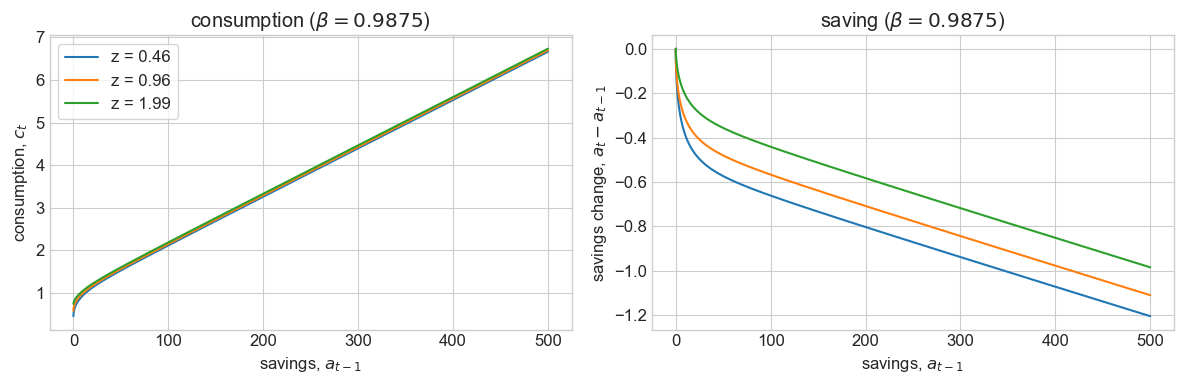

In [8]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid_ss[::3]):
        ax.plot(par.a_grid[I],sol.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid_ss[::3]):
        ax.plot(par.a_grid[I],sol.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

    fig.tight_layout()

## Simulation

The distribution is in `sim.D` where `sim.D.shape == [par.Nbeta,2,par.Na]`

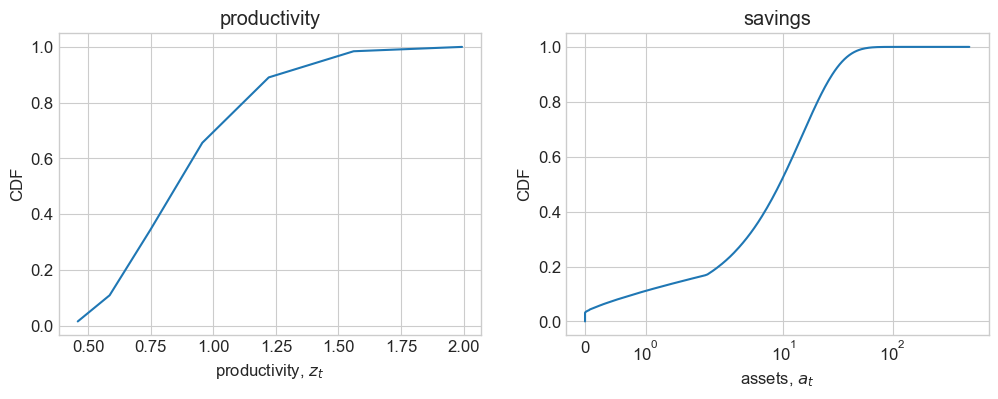

In [9]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
ax.plot(par.z_grid_ss,np.cumsum(np.sum(sim.D,axis=(0,2))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(sim.D,axis=(0,1))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

**Income moments:**

In [10]:
mean_z = np.sum(sim.D*par.z_grid_ss[:,np.newaxis])
std_z = np.sqrt(np.sum(sim.D*(par.z_grid_ss[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.30


**Asset moments:**

In [11]:
# a. prepare
Da = np.sum(sim.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a: 12.509
p25  a:  3.545
p50  a:  9.274
p95  a: 35.143
p99  a: 50.170
std. a: 11.620


**MPC:**

In [12]:
MPC = np.zeros(sim.D.shape)
MPC[:,:,:-1] = (sol.c[:,:,1:]-sol.c[:,:,:-1])/( (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1])
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*sim.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

mean MPC: 0.044 [annual: 0.164]


# Tests

Here we run a couple of tests to show that the code behaves as expected. Can be valuable when developing a new model.

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 2.4 secs
household problem simulated along transition in 4.8 secs


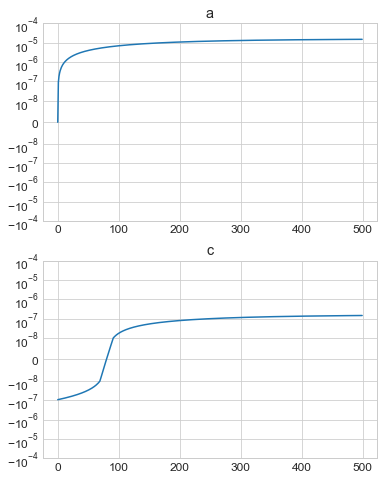

In [13]:
model.test_hh_path()

**Full transition path:**

In [14]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A_hh           : t0 =  1.6e-14, max abs.  1.5e-05
A              : t0 =  0.0e+00, max abs.  0.0e+00
C_hh           : t0 =  4.4e-16, max abs.  2.4e-07
C              : t0 =  0.0e+00, max abs.  0.0e+00
K              : t0 =  0.0e+00, max abs.  0.0e+00
L              : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  1.7e-18, max abs.  1.7e-18
rk             : t0 =  0.0e+00, max abs.  0.0e+00
w              : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0 =  0.0e+00, max abs.  0.0e+00
Z              : t0 =  0.0e+00, max abs.  0.0e+00

absolute value (potential targets):
clearing_A     : t0 = -1.6e-14, max abs.  1.5e-05
clearing_C     : t0 =  9.3e-08, max abs.  1.5e-07


**Calculation of Jacobians:**

note: differences should only be due to numerical errors

direct method:
finding jacobian wrt. ghost: 0 50 150 250 [computed in 0.6 secs]
finding jacobian wrt. r  : 0 50 150 250 [computed in 0.5 secs]
finding jacobian wrt. w  : 0 50 150 250 [computed in 0.6 secs]
all Jacobians computed in 1.8 secs

fake news method:
inputname = ghost: household Jacobian computed in 3.7 secs
inputname = r: household Jacobian computed in 0.5 secs
inputname = w: household Jacobian computed in 0.5 secs
all Jacobians computed in 4.8 secs


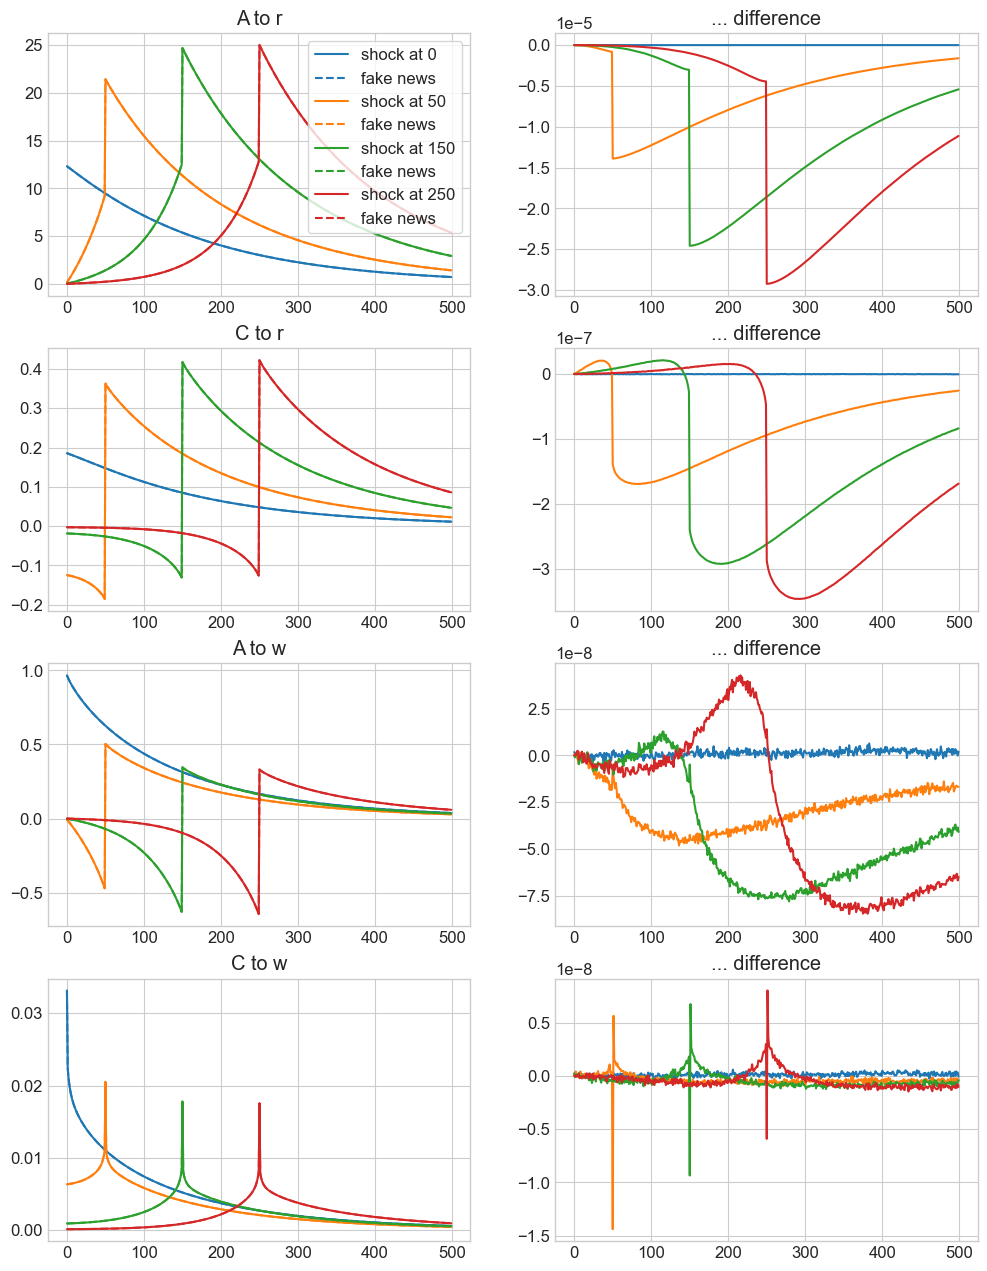

In [15]:
s_list = [0,50,150,250]
model.test_jac_hh(s_list)

# Jacobian of household problem at steady state

In [16]:
model.compute_jac_hh(do_print=True)

inputname = ghost: household Jacobian computed in 0.4 secs
inputname = r: household Jacobian computed in 0.5 secs
inputname = w: household Jacobian computed in 0.5 secs
all Jacobians computed in 1.5 secs


The **household Jacobians** are now in `model.jac_hh`. E.g. `model.jac_hh.A_r`.

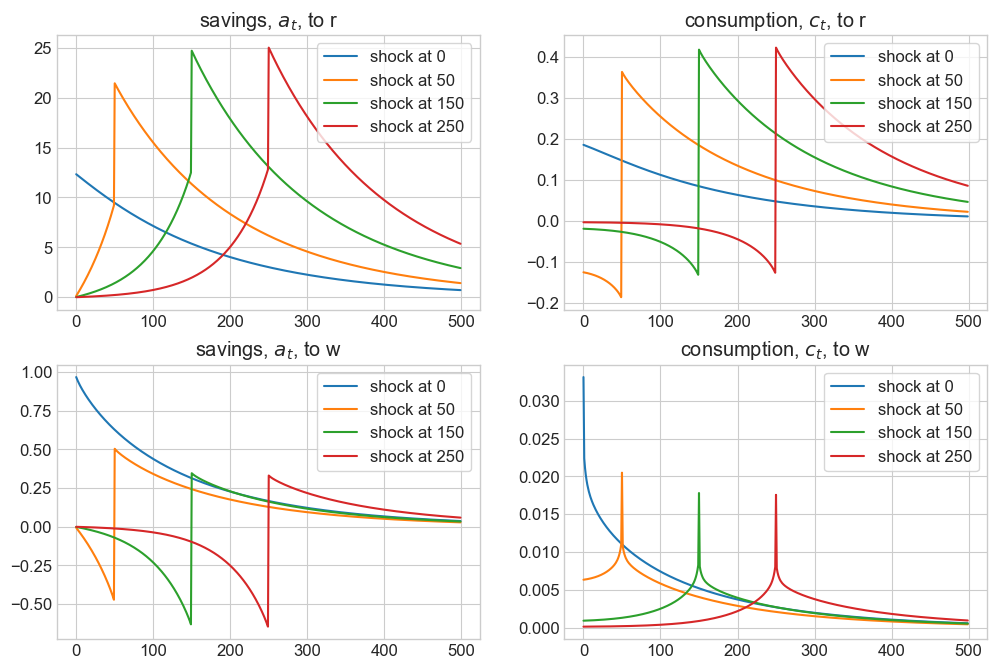

In [17]:
fig = plt.figure(figsize=(12,len(model.inputs_hh)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = getattr(model.jac_hh,f'A_{varname}')
        ax.plot(np.arange(par.transition_T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = getattr(model.jac_hh,f'C_{varname}')
        ax.plot(np.arange(par.transition_T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)
    

# Transition path

## Find transition path

**Compute full Jacobian at steady state:**

In [18]:
model.compute_jac(do_print=True)

full Jacobian to exogenous inputs computed in 0.3 secs [in evaluate_path(): 0.1 secs]


The **full Jacobian** is now in `model.jac`.

**Find transition paths:**

In [19]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error =  6.6e-02
 it =   1 -> max. abs. error =  6.4e-05
 it =   2 -> max. abs. error =  1.3e-07
 it =   3 -> max. abs. error =  6.4e-11

transition path found in 0.8 secs


**Results:** We now have

1. The transition path of all variables, `path.VARNAME[0,:]`
1. The transition path of policy functions, `sol.path_a` and `sol.path_c`
1. The transition path of distributions, `sim.path_D`

The **timing** is such that `path.A[t] == np.sum(sol.path_a[t]*sim.path_D[t])`.

## Plot transitions

### inputs, exogenous ###


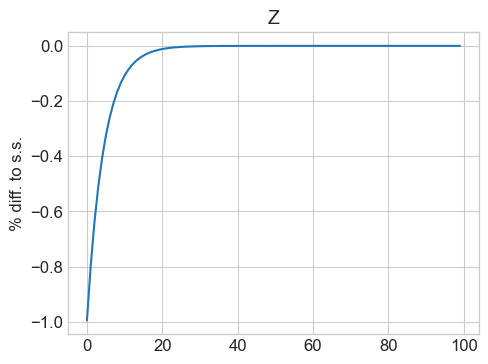


### paths ###


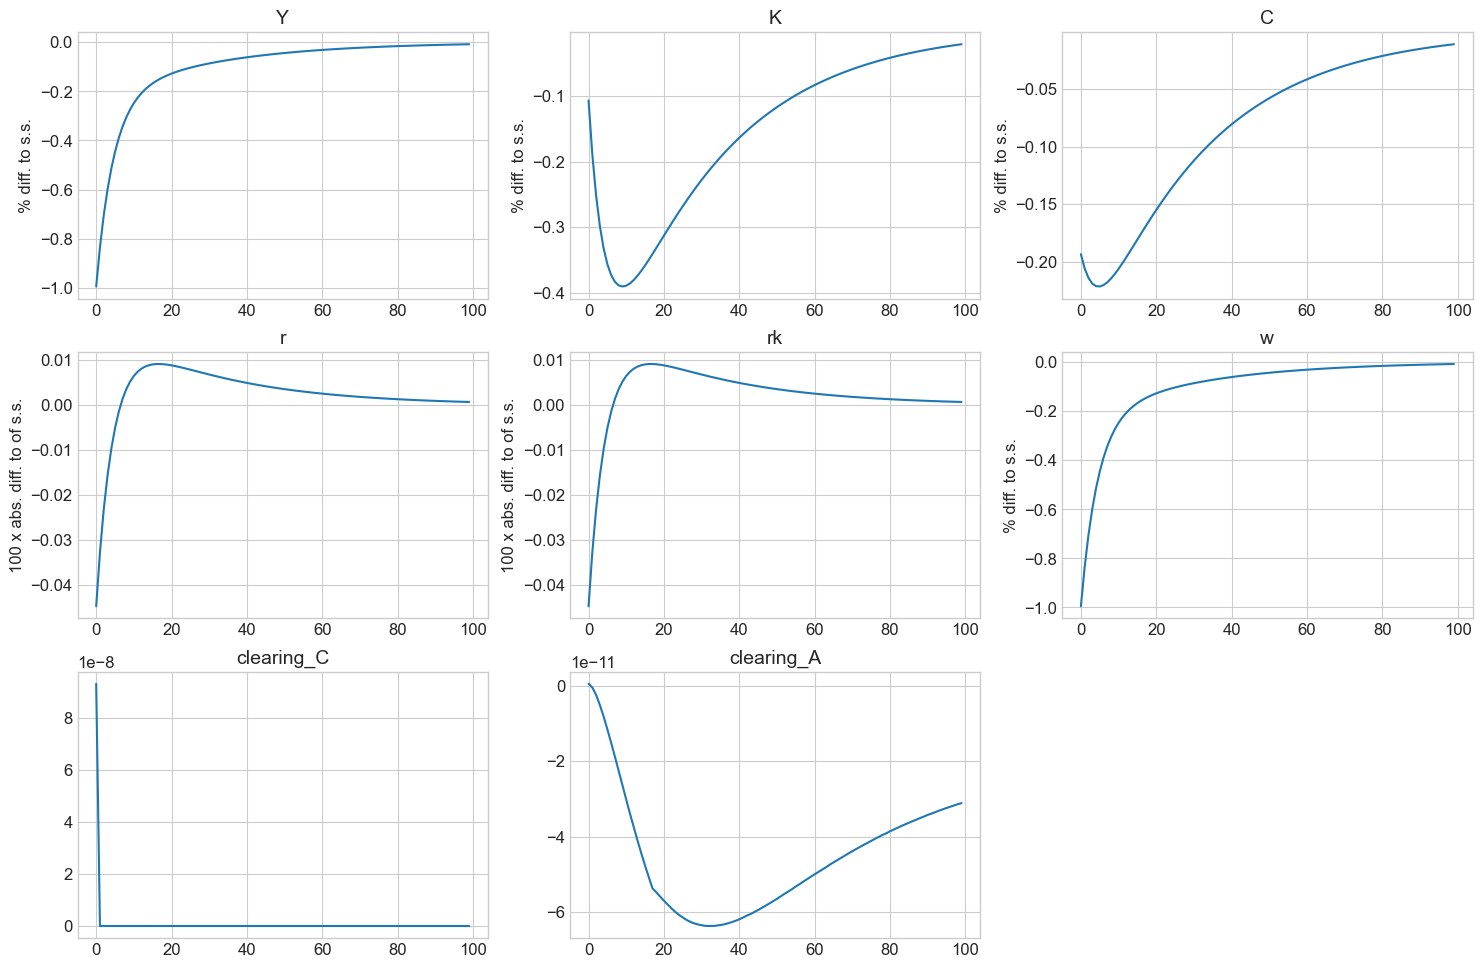


### tagets ###


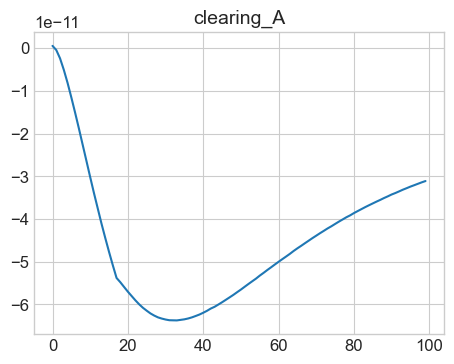

In [20]:
paths = ['Y','K','C','r','rk','w','clearing_C','clearing_A']
abs_value = ['r','rk']
facs = {'r':100,'rk':100}
model.show_IRFs(paths,abs_value,facs=facs,ncols=3,T_max=100)

## Linearized

**Compute the Jacobian for the exogenous inputs at steady state:**

In [21]:
model.compute_jac(do_print=True,exo=True)

full Jacobian to endogenous inputs computed in 0.2 secs [in evaluate_path(): 0.1 secs]


Saved in `model.jac_exo`.

**Find linear transition paths:**

In [22]:
model.find_transition_path_linear(do_print=True,reuse_G=False)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


**Results:** We now have `.dlinpath[(outputvarname,inputvarname)]` with the linear transition path of all variables.

### inputs, exogenous ###


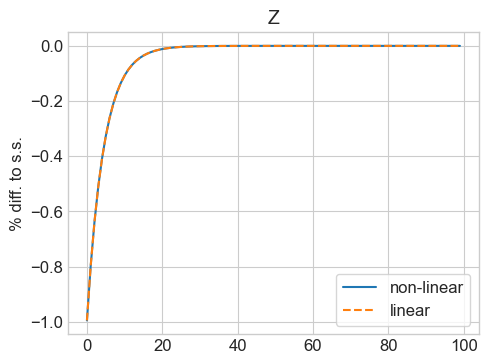


### paths ###


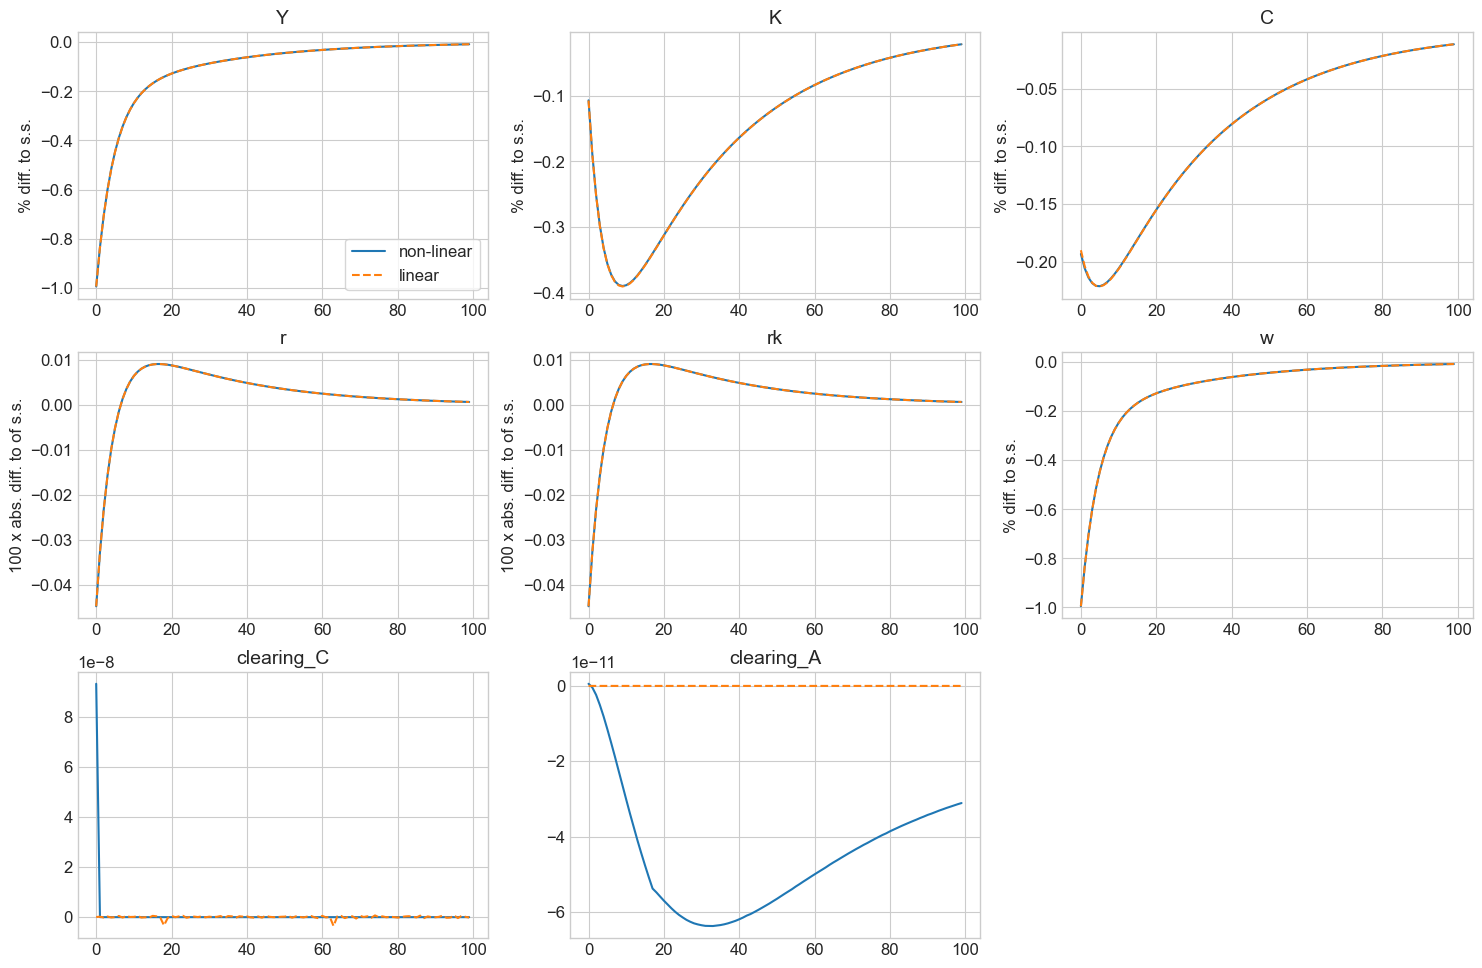


### tagets ###


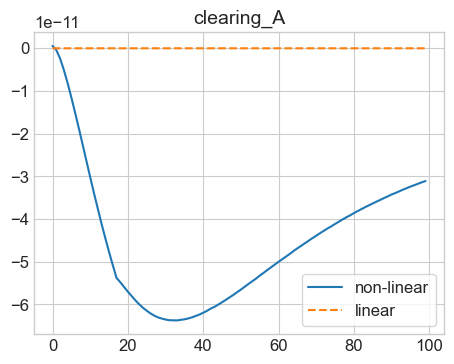

In [23]:
model.show_IRFs(paths,abs_value,facs=facs,ncols=3,T_max=100,do_linear=True)

# Speed

In [24]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.2 secs [1514 iterations]
household problem in ss simulated in 0.2 secs [2253 iterations]


In [25]:
model.solve_hh_path(do_print=True)
model.simulate_hh_path(do_print=True)

household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.0 secs


In [26]:
model.compute_jac_hh(do_print=True)

inputname = ghost: household Jacobian computed in 0.5 secs
inputname = r: household Jacobian computed in 0.5 secs
inputname = w: household Jacobian computed in 0.5 secs
all Jacobians computed in 1.6 secs


In [27]:
model.compute_jac(do_print=True)

full Jacobian to exogenous inputs computed in 0.3 secs [in evaluate_path(): 0.1 secs]


In [28]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error =  6.6e-02
 it =   1 -> max. abs. error =  6.4e-05
 it =   2 -> max. abs. error =  1.3e-07
 it =   3 -> max. abs. error =  6.4e-11

transition path found in 0.9 secs


In [29]:
model.compute_jac(do_print=True,exo=True)

full Jacobian to endogenous inputs computed in 0.3 secs [in evaluate_path(): 0.2 secs]


In [30]:
model.find_transition_path_linear(do_print=True)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


# Misc.

This is the **unpacking code lines** typically used in the begining of `transtion_path.evaluate_path()`.

In [31]:
model.print_unpack_varlist()

    for thread in nb.prange(threads):

        # unpack
        A_hh = path.A_hh[thread,:]
        A = path.A[thread,:]
        C_hh = path.C_hh[thread,:]
        C = path.C[thread,:]
        clearing_A = path.clearing_A[thread,:]
        clearing_C = path.clearing_C[thread,:]
        K = path.K[thread,:]
        L = path.L[thread,:]
        r = path.r[thread,:]
        rk = path.rk[thread,:]
        w = path.w[thread,:]
        Y = path.Y[thread,:]
        Z = path.Z[thread,:]


This code can be used to **update aggregate settings**:

In [32]:
model.update_aggregate_settings(inputs_endo=None,inputs_exo=None,targets=None)